# IMPORTANDO LIBRERIAS

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split

# CARGA DE DATOS


In [2]:
df_ratings = pd.read_csv('../data/ratings_filtered.csv')

In [3]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016557 entries, 0 to 11016556
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 336.2 MB


In [4]:
df_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1246,5.0,1425941556
4,1,1968,4.0,1425942148


In [5]:
df_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [6]:
df_ratings.shape

(11016557, 4)

In [7]:
df_ratings = df_ratings[:7000000]
df_ratings = df_ratings.drop('timestamp', axis=1).sample(frac=1).reset_index(drop=True)

# MODELAMIENTO

In [8]:
# Create user-item matrix and delete df_ratings to save memory
user_item_matrix = df_ratings.pivot(index = 'userId', columns = 'movieId', values = 'rating')
del df_ratings

In [9]:
user_item_matrix

movieId,2,3,5,6,11,12,13,14,15,16,...,175503,175553,175555,175587,175597,175791,176037,176077,176085,176143
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172038,2.0,1.0,2.5,1.0,2.0,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172039,1.5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Binarize the ratings (0 if not rated, 1 if rated)
user_item_matrix_binary = (user_item_matrix > 0).astype(int)
del user_item_matrix

In [11]:
user_item_matrix_binary

movieId,2,3,5,6,11,12,13,14,15,16,...,175503,175553,175555,175587,175597,175791,176037,176077,176085,176143
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172038,1,1,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
172039,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
172040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Create a map with key as movieId and value as index in user_item_matrix_binary
movieId_to_index = {}
index_to_movieId = {}
for index, movieId in enumerate(user_item_matrix_binary.columns):
    movieId_to_index[movieId] = index
    index_to_movieId[index] = movieId

In [13]:
# Save movieId_to_index as json and index_to_movieId as json
with open('../data/movieId_to_index.json', 'w') as f:
    json.dump(movieId_to_index, f)
with open('../data/index_to_movieId.json', 'w') as f:
    json.dump(index_to_movieId, f)
del movieId_to_index, index_to_movieId

In [14]:
# Split the data into training and test sets
train_data, test_data = train_test_split(user_item_matrix_binary, test_size=0.2, random_state = 42)

In [15]:
# RBM parameters
num_visible = num_items = user_item_matrix_binary.shape[1]
num_hidden = 50
batch_size = 64
epochs = 20

In [16]:
# Delete user_item_matrix_binary to save memory
del user_item_matrix_binary

In [17]:
# Build the RBM model
def rbm_model(num_visible : int, num_hidden : int):
    visible_layer = Input(shape=(num_visible,))
    hidden_layer = Dense(num_hidden, activation='sigmoid')(visible_layer)
    visible_layer_reconstructed = Dense(num_visible, activation='sigmoid')(hidden_layer)
    return Model(inputs = visible_layer, outputs = visible_layer_reconstructed)

In [18]:
rbm = rbm_model(num_visible, num_hidden)

In [19]:
rbm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6990)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       349,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6990)           │       356,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 706,040 (2.69 MB)

 Trainable params: 706,040 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Compile the RBM model
rbm.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'mean_squared_error')

In [21]:
# Train the RBM model
history = rbm.fit(train_data, train_data, batch_size = batch_size, epochs = epochs, shuffle = True, validation_data = (test_data, test_data))

Epoch 1/20
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 0.0928 - val_loss: 0.0088
Epoch 2/20
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0076 - val_loss: 0.0064
Epoch 3/20
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 4/20
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 5/20
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 6/20
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 7/20
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 8/20
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 9/20
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 10/20
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 11/20
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 12/20
2108/2

# Experiments

In [22]:
# Extract the embeddings
user_embedding = rbm.layers[1].get_weights()[0].T
item_embedding = rbm.layers[1].get_weights()[0]

In [23]:
# Verify the shape of the embeddings
user_embedding.shape

(50, 6990)

In [24]:
# Load dataset.json to process the data
data = {}
movieId_to_index = {}
index_to_movieId = {}
with open('../data/dataset.json', 'r') as f:
    data = json.load(f)
with open('../data/movieId_to_index.json', 'r') as f:
    movieId_to_index = json.load(f)
    
movieId_to_index = {int(movie_id): index for movie_id, index in movieId_to_index.items()}    
# Only save ids that are in movieId_to_index        
new_data = [d for d in data if d["id"] in movieId_to_index]
with open('../data/dataset2.json', 'w') as f:
    json.dump(new_data, f)
del movieId_to_index

In [25]:
# Function to recommend the top N movies for a user
def n_recommendations(user_id : int, n : int):
    user_movies = user_embedding[user_id - 1] 
    predicted_ratings = np.dot(user_embedding, user_movies)
    recommended_movies = np.argsort(predicted_ratings)[::-1][:10]
    return recommended_movies[:n]

In [26]:
# Function to predict ratings for a new user
def predict_ratings_for_new_user(new_user_interactions, n):
    # Create a new user vector
    new_user_vector = np.zeros((1, user_embedding.shape[1]))
    
    movieId_to_index = {}
    index_to_movieId = {}
    with open('../data/movieId_to_index.json', 'r') as file:
        movieId_to_index = json.load(file)
    with open('../data/index_to_movieId.json', 'r') as file:
        index_to_movieId = json.load(file)
        
    movieId_to_index = {int(movie_id): index for movie_id, index in movieId_to_index.items()}
    index_to_movieId = {int(index): movie_id for index, movie_id in index_to_movieId.items()}

    seen_movies_indices = set()
    for movie_id, rating in new_user_interactions.items():
        index = movieId_to_index[movie_id]
        new_user_vector[0, index] = rating > 0
        # Save the indices of the movies that the user has seen
        if rating > 0: 
                seen_movies_indices.add(index)
    
    # Multiply the user vector with the item embeddings to get the predicted ratings
    predicted_ratings = np.dot(user_embedding, new_user_vector[0])
    # Argsort to get the indices of the movies with the highest predicted ratings
    recommended_movies = np.argsort(predicted_ratings)[::-1][:n]
    # Convert the indices of user_matrix_binary to movieId and verify if the movie has been seen by the user
    recommended_movie_ids = [index_to_movieId[index] for index in recommended_movies if index not in seen_movies_indices]
    return recommended_movie_ids

In [27]:
# Example of use of the n_recommendations function
interactions = {'6520': 3, '27793': 3}
new_user_interactions = {int(movie_id): rating for movie_id, rating in interactions.items()}
print(predict_ratings_for_new_user(new_user_interactions, 10))

[65, 24, 11, 66, 35, 80, 33, 82, 22, 85]


In [28]:
# Save the model to a file
rbm.save('../rbm2.h5')

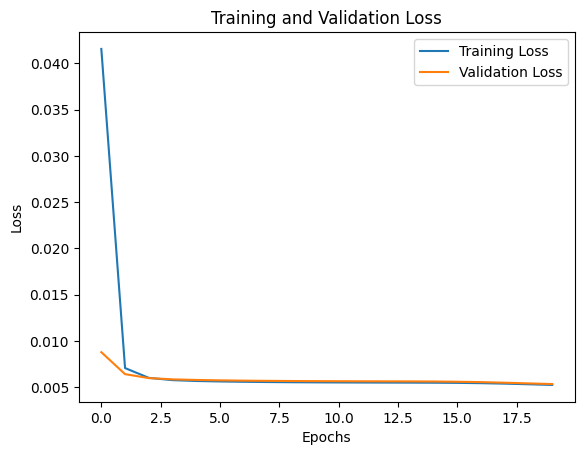

In [29]:
# Plotting the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()